In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns; sns.set()
plt.style.use('seaborn')
from collections import Counter
import json
import folium
import branca.colormap as cm

In [2]:
data_folder = 'data/'
data = pd.read_csv(data_folder + 'en.openfoodfacts.org.products.csv', sep='\t')

/home/painguin/anaconda3/lib/python3.6/site-packages/IPython/core/interactiveshell.py:2785: DtypeWarning: Columns (0,3,5,24,25,26,28,36,41,49) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


# Data Preprocessing

### Chosen Fields

(at least some text that explains why we dropped the other fields)

In [3]:
chosen_fields = ['product_name', 'packaging_tags', 'brands_tags',
                 'origins_tags', 'manufacturing_places_tags', 'labels_en', 'stores', 'countries_en',
                 'additives_n', 'ingredients_from_palm_oil_n', 'ingredients_that_may_be_from_palm_oil_n', 
                 'nutrition_grade_fr', 'pnns_groups_1', 'fruits-vegetables-nuts_100g',
                 'main_category_en', 'energy_100g', 'energy-from-fat_100g', 'fat_100g', 
                 'saturated-fat_100g', 'monounsaturated-fat_100g', 'polyunsaturated-fat_100g', 
                 'omega-3-fat_100g', 'omega-6-fat_100g', 'omega-9-fat_100g', 'trans-fat_100g', 
                 'cholesterol_100g', 'carbohydrates_100g', 'sugars_100g', 'fiber_100g', 'proteins_100g', 'sodium_100g', 
                 'nutrition-score-fr_100g', 'nutrition-score-uk_100g', 'carbon-footprint_100g', 'first_packaging_code_geo']

data = data[chosen_fields]

## Field Cleaning

The 'pnns_groups_1' field is particularly usefull in our study. 
Indeed, it sorts the different food entries by some clear category, as seen below.

A simple map allows for better organisation and also cleans the duplicate field entries:

In [4]:
pnns1_clean_map = {'unknown' : 'Unknown',
 'Sugary snacks' : 'Snacks', 
 'Milk and dairy products' : 'Dairies',
 'Composite foods' : 'Composite', 
 'Cereals and potatoes' : 'Starchy', 
 'Fish Meat Eggs' : 'Fish Meat Eggs',
 'Beverages' : 'Beverages',
 'Fat and sauces' : 'Fat Sauces',
 'Fruits and vegetables' : 'Fruits Vegetables',
 'Salty snacks' : 'Snacks',
 'fruits-and-vegetables' : 'Fruits Vegetables',
 'sugary-snacks' : 'Snacks',
 'cereals-and-potatoes' : 'Starchy',
 'salty-snacks' : 'Snacks'
}

data['Category'] = data['pnns_groups_1'].replace(pnns1_clean_map)

Now the categories are clear:

In [5]:
data['Category'].value_counts()

Unknown              122881
Snacks                37054
Dairies               17948
Composite             14670
Starchy               14612
Fish Meat Eggs        13993
Fruits Vegetables     12632
Beverages             12411
Fat Sauces            11427
Name: Category, dtype: int64

From the 'main_category_en' field, we can recover more entries for the previous categories, as well as a new meaningfull category 'Plant-based foods and beverages', that we will rename 'Veggie' and add it as a new binary field in the data set.

In [6]:
data['main_category_en'].value_counts().head(20)

Plant-based foods and beverages    38524
Beverages                          26110
Sugary snacks                      25209
Dairies                            16145
Meats                               9801
Groceries                           9703
Meals                               8349
Spreads                             4629
Frozen foods                        3154
Fruit juices                        3108
Desserts                            3080
Salty snacks                        3008
Seafood                             2921
Canned foods                        2770
Fats                                1878
Baby foods                          1037
Sweeteners                           945
Sandwiches                           905
Farming products                     798
Fish and meat and eggs               741
Name: main_category_en, dtype: int64

First the usefull categories of `pnns_groups_1` and `main_category_en` are merged.
This merged categorical field is called `category`.

In [7]:
category_map = {
    'Beverages' : 'Beverages',
    'Sugary snacks' : 'Snacks',
    'Dairies' : 'Dairies',
    'Meats' : 'Fish Meat Eggs',
    'Meals' : 'Composite',
    'Fruit juices' : 'Beverages',
    'Salty snacks' : 'Snacks',
    'Fats' : 'Fat Sauces',
    'Fish and meat and eggs' : 'Fish Meat Eggs'
}

In [8]:
not_in_category = data[data['Category'].isna()]
keys = category_map.keys()
not_in_category.query('main_category_en in @keys')['main_category_en'].value_counts()

Beverages                 5844
Meats                       68
Meals                       16
Fish and meat and eggs      12
Name: main_category_en, dtype: int64

We see that the number of usefull entries that are not already present in `pnns_group_1` are mainly from the `Beverages` category. Nonetheless, we build the new `Category` field as previously exposed, and add these categories, as well as the `pnns_group_1` fields.

In [9]:
# Adds the values in 'main_category_en' that are not in 'pnns_groups_1' after applying the map
new_vals = not_in_category.query('main_category_en in @keys')['main_category_en'].replace(category_map)
data.loc[new_vals.index, 'Category'] = new_vals

Here is the new 'Category' field.

In [10]:
data['Category'].value_counts()

Unknown              122881
Snacks                37054
Beverages             18255
Dairies               17948
Composite             14686
Starchy               14612
Fish Meat Eggs        14073
Fruits Vegetables     12632
Fat Sauces            11427
Name: Category, dtype: int64

Now the `Plant based food and beverages category` is used to create a new field called `Veggie`.

In [11]:
data['Veggie'] = data['main_category_en'] == 'Plant-based foods and beverages'

The veggie fields from `Category` are also added:

In [12]:
data['Veggie'] = data['Veggie'] | (data['Category'] == 'Fruits Vegetables')
data['Veggie'] = data['Veggie'] | (data['Category'] == 'Starchy')

In [13]:
data['Veggie'].value_counts()

False    658551
True      39926
Name: Veggie, dtype: int64

Notice that the `False` value doesn't mean that an entry is not veggie.

# Nutri-Score

The Nutri-Score system was developped after Article 14 of the Modernisation Law for the health system, dated 26 January 2016, required the french authorities to recommend a front-of-pack system of labelling that would be simple and accessible for all. 
The new system includes a colour coded scheme, ranging from green to orange, associated with letters from A to E. Productes designated with an 'A' have the best nutritional quality, while products designated with an E have poorer nutritional quality.

## Points A

| Points | Energy (kJ) | Fat (g) | Sugar (g) | Sodium (mg) |
|:------:|:-----------:|:-------:|:---------:|:-----------:|
|    0   |    <=335    |   <=1   |   <=4.5   |     <=90    |
|    1   |     >335    |    >1   |    >4.5   |     >90     |
|    2   |     >670    |    >2   |     >9    |     >180    |
|    3   |    >1005    |    >3   |   >13.5   |     >270    |
|    4   |    >1340    |    >4   |    >18    |     >360    |
|    5   |    >1675    |    >5   |   >22.5   |     >450    |
|    6   |    >2010    |    >6   |    >27    |     >540    |
|    7   |    >2345    |    >7   |    >31    |     >630    |
|    8   |    >2680    |    >8   |    >36    |     >720    |
|    9   |    >3015    |    >9   |    >40    |     >810    |
|   10   |    >3350    |   >10   |    >45    |     >900    |

## Points C

| Points | Fruits Vegetables Nuts (%) | Fiber (g) | Proteins (g) |
|:------:|:--------------------------:|:---------:|:------------:|
|    0   |            <=40            |   <=0.9   |     <=1.6    |
|    1   |             >40            |    >0.9   |     >1.6     |
|    2   |             >60            |    >1.9   |     >3.2     |
|    3   |              -             |    >2.8   |     >4.8     |
|    4   |              -             |    >3.7   |     >6.4     |
|    5   |             >80            |    >4.7   |     >8.0     |

## Nutri-Score Computation
  * If `points A` < 11, then `score` = `points A` - `points C`
  * If `points A` >= 11:
      * If `points(Fruits/Vegetables/Nuts)` = 5, then `score` = `points(A)` - `points(C)`
      * If `points(Fruits/Vegetables/Nuts)` < 5, then `score` = `points(A)` - (`points(Fiber)` + `points(Fruits/Vegetables/Nuts)`)

## Letters Thresholds
### Solid Food
  * A: until -1
  * B: from 0 to 2
  * C: from 3 to 10
  * D: from 11 to 18
  * E: 19 and more
  
### Beverages 
  * A: mineral and spring water
  * B: until 1
  * C: from 2 to 5
  * D: from 6 to 9
  * E: 10 and more

## Warning
When fiber content is not present, its eventual positive contribution is not taken into account.

Percentages corresponding to Fruits/Vegetables/Nuts are mainly missing from the packaging. 
It will be derived from other products as follows:
  * 100% : Fruit Juices
  * 90% : Fruit Compote
  * 85% : Vegetables
  * 50% : Jams
  
Tubers are not considered as vegetables for the nutri-score.

In [14]:
data[(data['main_category_en'] == 'Fruit juices')]['fruits-vegetables-nuts_100g'].fillna(100, inplace=True)

/home/painguin/anaconda3/lib/python3.6/site-packages/pandas/core/generic.py:5430: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._update_inplace(new_data)


In [15]:
beverages = data.query('Category == "Beverages"')

#### Compute points A

In [16]:
# energy
energy_bins = [data['energy_100g'].min() - 1, 335, 670, 1005, 1340, 1675, 2010, 2345, 2680, 3015, 3350, data['energy_100g'].max()]
data['energy_points'] = pd.cut(data['energy_100g'], energy_bins, labels=range(11)).astype(float)

# fat
fat_bins = [data['fat_100g'].min() - 1, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, data['fat_100g'].max()]
data['fat_points'] = pd.cut(data['fat_100g'], fat_bins, labels=range(11)).astype(float)

# sugar
sugar_bins = [data['sugars_100g'].min() - 1, 4.5, 9, 13.5, 18, 22.5, 27, 31, 36, 40, 45, data['sugars_100g'].max()]
data['sugar_points'] = pd.cut(data['sugars_100g'], sugar_bins, labels=range(11)).astype(float)

# sodium
sodium_bins = [data['sodium_100g'].min() - 1, 90, 180, 270, 360, 450, 540, 630, 720, 810, 900, data['sodium_100g'].max()]
data['sodium_points'] = pd.cut(data['sodium_100g'], sodium_bins, labels=range(11)).astype(float)

data['points_A'] = data['energy_points'] + data['fat_points'] + data['sugar_points'] + data['sodium_points']

#### Compute points C

In [17]:
# fruits-vegetables-nuts
fvn_bins = [data['fruits-vegetables-nuts_100g'].min() - 1, 40, 60, 80, data['fruits-vegetables-nuts_100g'].max()]
data['fvn_points'] = pd.cut(data['fruits-vegetables-nuts_100g'], fvn_bins, labels=[0,1,2,5]).astype(float)
data['fvn_points'].fillna(0, inplace=True)

# fiber
fiber_bins = [data['fiber_100g'].min() - 1, 0.9, 1.9, 2.8, 3.7, 4.7, data['fiber_100g'].max()]
data['fiber_points'] = pd.cut(data['fiber_100g'], fiber_bins, labels=range(6)).astype(float)
data['fiber_points'].fillna(0, inplace=True)

# proteins
proteins_bins = [data['proteins_100g'].min() - 1, 1.6, 3.2, 4.8, 6.4, 8.0, data['proteins_100g'].max()]
data['proteins_points'] = pd.cut(data['proteins_100g'], proteins_bins, labels=range(6)).astype(float)
data['proteins_points'].fillna(0, inplace=True)

data['points_C'] = (data['fvn_points'] + data['fiber_points'] + data['proteins_points'])

#### Compute nutri-score

We first compute the nutri-score based on the rules formula mentioned ahead.

In [18]:
def compute_score(row):
    A = row['points_A']
    C = row['points_C']
    fvn = row['fvn_points']
    fiber = row['fiber_points']
    if A < 11 or fvn == 5:
        return A - C
    else:
        return A - (fiber + fvn)

In [19]:
data['nutri-score'] = data.apply(compute_score, axis=1)

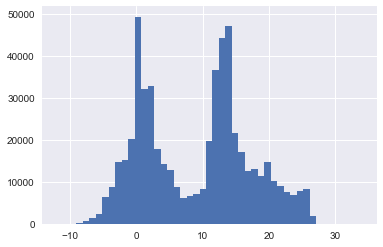

In [20]:
data['nutri-score'].hist(bins=int(data['nutri-score'].max() - data['nutri-score'].min() + 1));

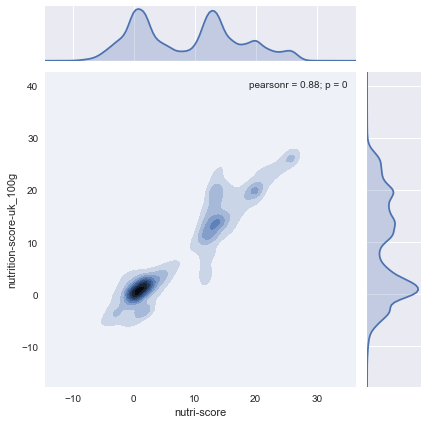

In [21]:
sns.jointplot(data['nutri-score'], data['nutrition-score-uk_100g'], kind='kde');

Now we assign the letter corresponding to the nutri-score.

In [22]:
def nutri_score_letter(row):
    nutri_score = row['nutri-score']
    product_name = row['product_name']
    
    # check if nutri_score is nan
    if nutri_score != nutri_score:
        return np.nan
    
    if row['Category'] == 'Beverages':
        if nutri_score <= 1:
            return 'B'
        elif nutri_score <= 5:
            return 'C'
        elif nutri_score <= 9:
            return 'D'
        else:
            return 'E'
    else:
        if nutri_score <= -1:
            return 'A'
        elif nutri_score <= 2:
            return 'B'
        elif nutri_score <= 10:
            return 'C'
        elif nutri_score <= 18:
            return 'D'
        else:
            return 'E'

In [23]:
data['nutri-score_letter'] = data.apply(nutri_score_letter, axis=1)

### Analyse the nutri-score across the categories

In [24]:
# Count the letter occurences for each category
letter_counts_per_cat = data.groupby(['Category', 'nutri-score_letter']).count()[['nutri-score']]
letter_counts_per_cat

nutri-score
Category          nutri-score_letter             
Beverages         B                          5318
                  C                          4425
                  D                            83
                  E                          1760
Composite         A                          2250
                  B                          3342
                  C                          4271
                  D                          3705
                  E                            12
Dairies           A                          1051
                  B                          2742
                  C                          4305
                  D                          7547
                  E                           346
Fat Sauces        A                           374
                  B                           979
                  C                          1967
                  D                          3322
                  E                          3283
Fish Meat Eggs    A                          2806
                  B                           871
                  C                           979
                  D                          6909
                  E                            33
Fruits Vegetables A                          3480
                  B                          3267
                  C                          1544
                  D                           793
                  E                           144
Snacks            A                           196
                  B                           646
                  C                          1824
                  D                         14996
                  E                         14889
Starchy           A                          5014
                  B                          2923
                  C                          2201
                  D                          2440
                  E                           168
Unknown           A                         14201
                  B                         22689
                  C                         17242
                  D                         38819
                  E                         12484

In [25]:
# For some categories, some letters are not represented. We add the missing rows with 0 as value.
for cat in letter_counts_per_cat.index.levels[0]:
    for letter in letter_counts_per_cat.index.levels[1]:
        if (cat, letter) not in letter_counts_per_cat.index:
            letter_counts_per_cat.loc[(cat, letter), :] = 0
            
letter_counts_per_cat.sort_index(inplace=True)

In [26]:
# normalize the counts
totals = letter_counts_per_cat.reset_index()[['Category', 'nutri-score']].groupby('Category').sum()
score_distr_per_cat = letter_counts_per_cat / totals

In [27]:
# colors similar to the original nutri-score ones
nutri_score_colors = ['green', 'limegreen', 'gold', 'darkorange', 'orangered']

/home/painguin/anaconda3/lib/python3.6/site-packages/pandas/plotting/_core.py:194: UserWarning: 'colors' is being deprecated. Please use 'color'instead of 'colors'
  warnings.warn(("'colors' is being deprecated. Please use 'color'"


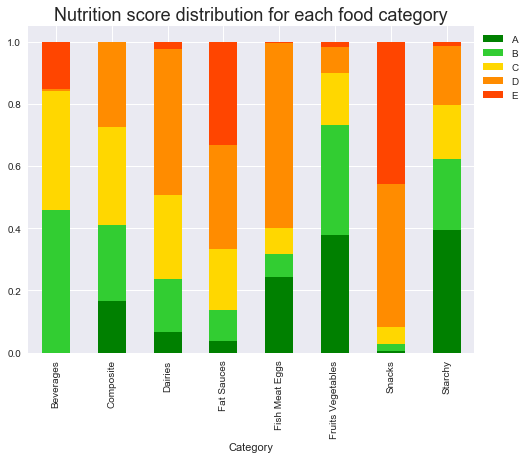

In [28]:
score_distr_per_cat.drop('Unknown').reset_index().pivot(index='Category', columns='nutri-score_letter', values='nutri-score').plot.bar(stacked=True, figsize=(8,6), colors=nutri_score_colors)
plt.legend(bbox_to_anchor=(1, 1.0))
plt.title('Nutrition score distribution for each food category', fontsize=18);

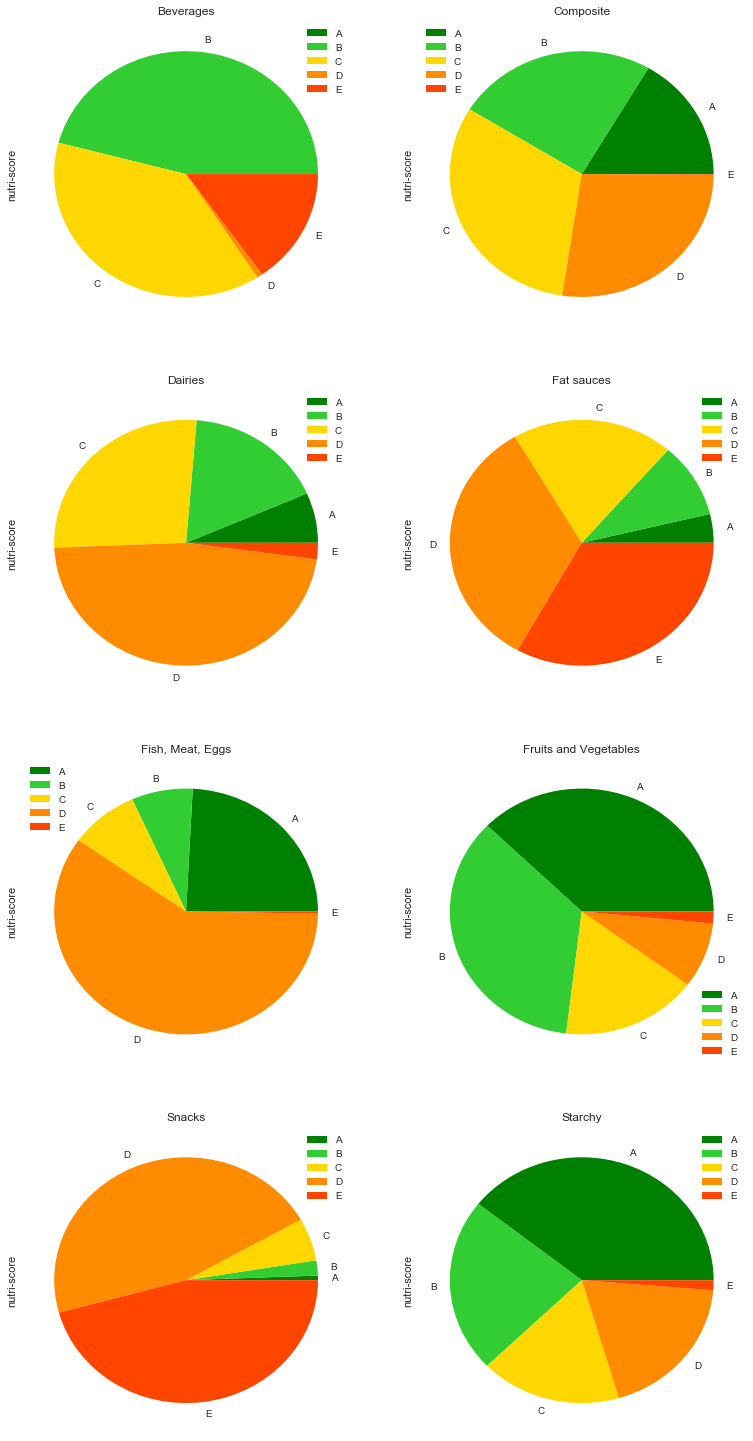

In [29]:
plt.figure(figsize=(13, 26))
letter_counts_per_cat.loc['Beverages'].plot.pie('nutri-score', ax=plt.subplot(421), title='Beverages', colors=nutri_score_colors)
letter_counts_per_cat.loc['Composite'].plot.pie('nutri-score', ax=plt.subplot(422), title='Composite', colors=nutri_score_colors)
letter_counts_per_cat.loc['Dairies'].plot.pie('nutri-score', ax=plt.subplot(423), title='Dairies', colors=nutri_score_colors)
letter_counts_per_cat.loc['Fat Sauces'].plot.pie('nutri-score', ax=plt.subplot(424), title='Fat sauces', colors=nutri_score_colors)
letter_counts_per_cat.loc['Fish Meat Eggs'].plot.pie('nutri-score', ax=plt.subplot(425), title='Fish, Meat, Eggs', colors=nutri_score_colors)
letter_counts_per_cat.loc['Fruits Vegetables'].plot.pie('nutri-score', ax=plt.subplot(426), title='Fruits and Vegetables', colors=nutri_score_colors)
letter_counts_per_cat.loc['Snacks'].plot.pie('nutri-score', ax=plt.subplot(427), title='Snacks', colors=nutri_score_colors)
letter_counts_per_cat.loc['Starchy'].plot.pie('nutri-score', ax=plt.subplot(428), title='Starchy', colors=nutri_score_colors)

In [30]:
score_mean_by_category = data[['Category', 'nutri-score']].groupby('Category').mean()
score_mean_by_category

,nutri-score
Category,
Beverages,3.279993
Composite,4.930707
Dairies,8.300419
Fat Sauces,12.614912
Fish Meat Eggs,7.547508
Fruits Vegetables,1.668401
Snacks,17.426838
Starchy,2.970971
Unknown,8.478646


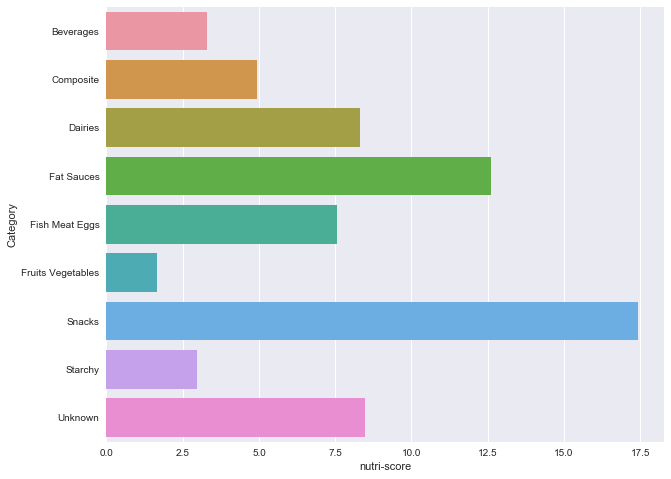

In [31]:
plt.figure(figsize=(10,8))
sns.barplot(score_mean_by_category['nutri-score'], score_mean_by_category.index,orient='h')

In [32]:
carbon_mean_by_category = data[['Category', 'carbon-footprint_100g']].groupby('Category').mean()

In [33]:
pd.concat((carbon_mean_by_category, score_mean_by_category), axis=1).corr()

,carbon-footprint_100g,nutri-score
carbon-footprint_100g,1.000000,0.210469
nutri-score,0.210469,1.000000


array([<matplotlib.axes._subplots.AxesSubplot object at 0x7f6df792aa90>,
      dtype=object)

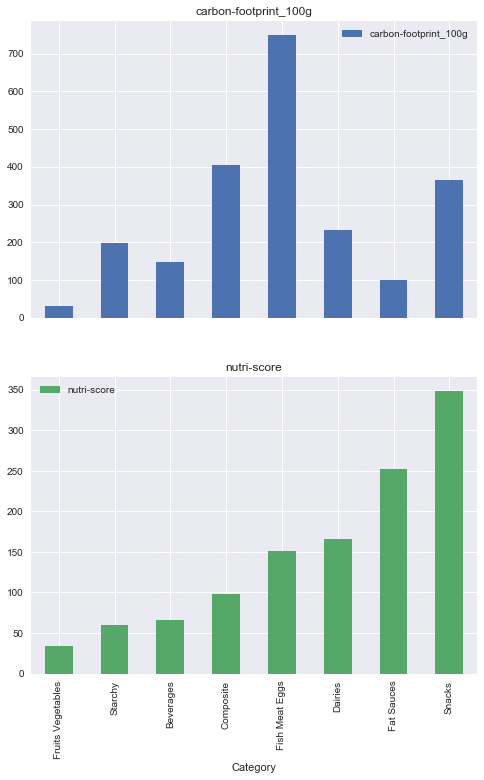

In [34]:
pd.concat((carbon_mean_by_category, 20*score_mean_by_category), axis=1).drop('Unknown').sort_values('nutri-score').plot.bar(subplots=True, figsize=(8, 12))

In [35]:
pack_mapping = dict.fromkeys(['plastic', 'plastique,frais','plastique', 'barquette,plastique', 'sachet,plastique',
                              'frais,plastique','carton,plastique','carton,plastique,surgele','flacon,plastique'
                 'sachet-plastique','carton,boite,plastique', 'boite,plastique', 'plastique,carton','sachet-plastique',
                'sachet,plastique,surgele','barquette,plastique,frais','pot,plastique','plastique,sachet',
                             'plastico','boite,carton,plastique','frais,plastique,carton','frais,carton,plastique',
                              'carton,sachet,plastique','kunststoff','barquette,film,plastique,sous-atmosphere-protectrice',
                             'carton,surgele,plastique','plastique,barquette','sachet,plastique,frais',
                             'barquette,plastique,sous-atmosphere-protectrice','frais,barquette,plastique,opercule,film-plastique,sous-atmosphere-protectrice',
                             'sachet,plastique,carton','film,plastique','carton,plastique,frais','frais,pot,plastique','sachet,plastique,sous-atmosphere-protectrice',
                             'bolsa-de-plastico,ultracongelado','barquette-plastique','plastique,sous-vide','plastic,bag',
                             'barquette,film,plastique'],'Plastic')

pack_mapping.update(dict.fromkeys(['bouteille,verre','carton','boite,carton','carton,surgele','karton','carton,boite','karton,kunststoff',
                                  'sachet,papier','papier','bouteille,plastique','conserve','bocal,verre','glas',
                                  'bouteille','conserve,metal','bocal,verre,couvercle,metal','bocal,verre,metal',
                                  'verre','verre,bouteille','pot,verre','bocal','bolsa-de-plastico','verre,bocal',
                                  'flacon,plastique','bouteille-plastique','bottle','canned','pot-en-verre','bolsa,plastico',
                                   'bouteille-verre','bocal-en-verre','verre,bocal,metal','plastique,bouteille','bouteille-en-verre','canette','pot,verre,couvercle,metal',
                                  'glas,mehrwegpfand','carton,aluminium','boite,metal','botella-de-plastico','boite-carton',
                                  'plastic-bottle','sous-vide','plastic,bottle','can','pot-en-plastique'],'Recyclable'))

pack_mapping.update(dict.fromkeys(['frais','surgele','surgele,carton,plastique','brique,carton','tetra-pak','tetra-brik',
                                  'brique',],'Non-Recyclable'))

In [36]:
data['packaging_tags'] = data['packaging_tags'].replace(pack_mapping)

In [37]:
nutri_pack = pd.DataFrame(data[['packaging_tags', 'nutri-score_letter']].dropna().groupby('nutri-score_letter').count())

In [38]:
nutri_pack['Plastic'] = data[['packaging_tags', 'nutri-score_letter']].dropna().query('packaging_tags == "Plastic"').groupby('nutri-score_letter').count()

nutri_pack['Recyclable'] = data[['packaging_tags', 'nutri-score_letter']].dropna().query('packaging_tags == "Recyclable"').groupby('nutri-score_letter').count()

nutri_pack['Non-Recyclable'] = data[['packaging_tags', 'nutri-score_letter']].dropna().query('packaging_tags == "Non-Recyclable"').groupby('nutri-score_letter').count()

In [39]:
nutri_pack.drop(columns = ['packaging_tags'], inplace = True)

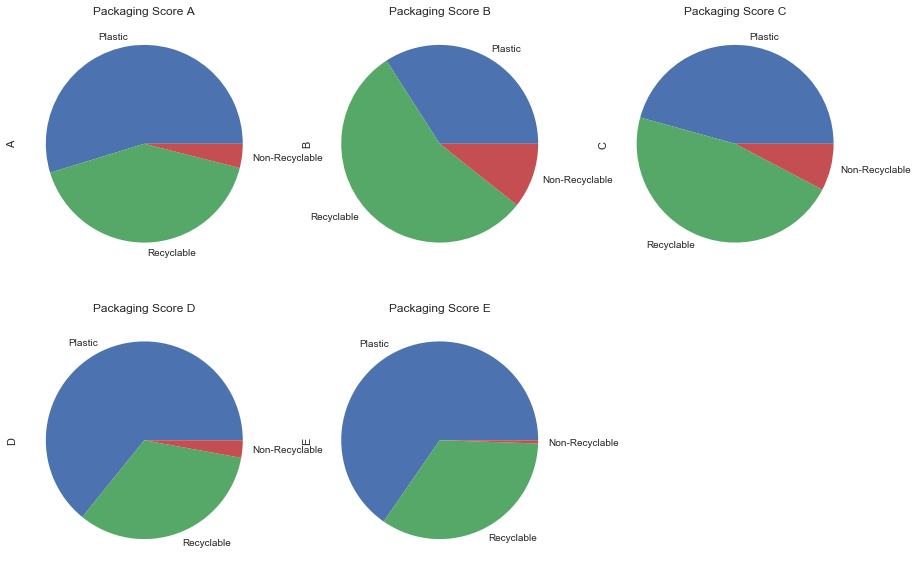

In [40]:
plt.figure(figsize = (15,10))
nutri_pack.loc['A'].plot.pie(ax=plt.subplot(231), title='Packaging Score A')
nutri_pack.loc['B'].plot.pie(ax=plt.subplot(232), title='Packaging Score B')
nutri_pack.loc['C'].plot.pie(ax=plt.subplot(233), title='Packaging Score C')
nutri_pack.loc['D'].plot.pie(ax=plt.subplot(234), title='Packaging Score D')
nutri_pack.loc['E'].plot.pie(ax=plt.subplot(235), title='Packaging Score E')

**Number of Ing containing Palm_oil**

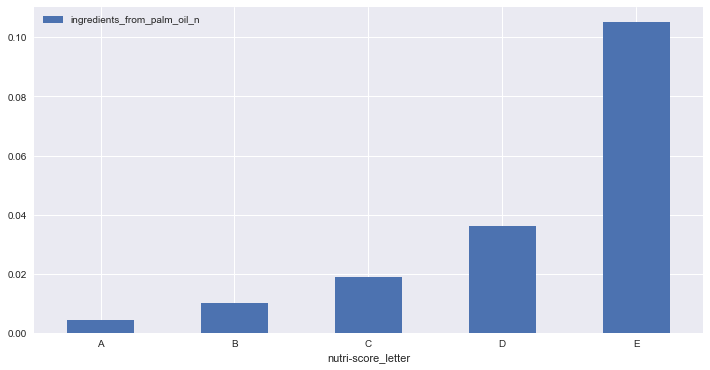

In [41]:
nutri_palm = data[['nutri-score_letter', 'ingredients_from_palm_oil_n']].groupby('nutri-score_letter').mean()
nutri_palm.plot.bar(rot=0, figsize = (12,6))

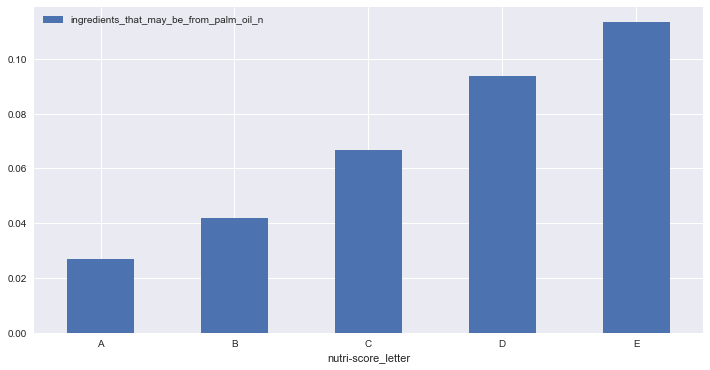

In [42]:
may_nutri_palm = data[['nutri-score_letter', 'ingredients_that_may_be_from_palm_oil_n']].groupby('nutri-score_letter').mean()
may_nutri_palm.plot.bar(rot=0, figsize = (12,6))

In [43]:
def replace(col, contains, replace_by):
    data.loc[data[col].str.contains(contains), col] = replace_by

In [44]:
data['labels_en'].fillna('Unknown', inplace = True)
replace('labels_en','organic','Bio')
replace('labels_en','biologique','Bio')
replace('labels_en','Biologique','Bio')
replace('labels_en','bio','Bio')
replace('labels_en','Organic','Bio')
replace('labels_en','vegan','Vegan')
replace('labels_en','Vegan','Vegan')

In [45]:
replace('labels_en','Green Dot','Green Dot')
replace('labels_en','veget','Vegetarian')
replace('labels_en','Veget','Vegetarian')

In [46]:
data['labels_en'].value_counts()

Unknown                                                                                                                            596228
Bio                                                                                                                                 38223
Green Dot                                                                                                                           19925
Vegan                                                                                                                                3876
Vegetarian                                                                                                                           1994
Made in France                                                                                                                        888
PDO                                                                                                                                   875
Gluten-free                       

In [47]:
data[['labels_en', 'nutri-score_letter']].dropna().query('labels_en == "Bio"').groupby('nutri-score_letter').count()

,labels_en
nutri-score_letter,
A,6131
B,7675
C,6232
D,9940
E,3701


In [48]:
data[['labels_en', 'packaging_tags']].dropna().query('labels_en == "Bio"').groupby('packaging_tags').count()

,labels_en
packaging_tags,
01-pet,1
"01-pet,02-pe-hd",2
"01-pet,05-pp",1
"01-pet,05-pp,plastic",1
"01-pet,pfandfrei,einweg",1
04-ldpe,1
04-pe-ld,2
"04-pe-ld,kunststoff",1
05-pp,12


### The nutri-score across the globe

The countries in `origins_tags` and `countries_en` are comma separated. We create a dataframe that contains every combination between the origin country and destination country for each product.

In [49]:
origins_countries_pairs = []

# keep track of the occurences in order to later preserve only the recurrent ones
origin_occurences = Counter()
countries_occurences = Counter()

for idx, row in data[['origins_tags', 'countries_en', 'nutri-score']].dropna().iterrows():
    origin_split = row['origins_tags'].split(',')
    countries_split = row['countries_en'].split(',')
    
    for orig in origin_split:
        origin_occurences[orig] += 1
        
    for country in countries_split:
        countries_occurences[country] += 1
    
    for orig in origin_split:
        for country in countries_split:
            origins_countries_pairs += [[idx, orig, country]]

In [50]:
threshold = 10

In [51]:
# drop the lowly represented countries
origins_countries_pairs_filtered = [tup for tup in origins_countries_pairs if origin_occurences[tup[1]] >= threshold and countries_occurences[tup[2]] > threshold]
origins_countries_pairs_np = np.array(origins_countries_pairs_filtered)

# create the dataframe consisting of (product_index, origin, destination)
travel_data = pd.DataFrame(origins_countries_pairs_np[:,1:], index=origins_countries_pairs_np[:,0], columns=['origin', 'destination'])
travel_data.index = travel_data.index.astype(int)

We merge the new dataframe with the original one to have access to the `nutri-score`.

In [52]:
travel_data_with_scores = travel_data.merge(data[['nutri-score']], left_index=True, right_index=True)
travel_data_with_scores.head()

,origin,destination,nutri-score
254,france,France,-1.0
257,quebec,Canada,11.0
267,quebec,Canada,18.0
277,quebec,Canada,16.0
288,quebec,Canada,-3.0


In order to display our results on the map, we load a json containing the geometry of the countries.

In [53]:
with open(data_folder + 'world-countries.json') as f:
    geo_json_countries = json.load(f)

countries_in_map = [country['properties']['name'] for country in geo_json_countries['features']]

Our country names don't exactly correspond to the ones in the json file. Therefore we do some cleaning on our dataframe (on the most represented and valid countries) to resolve this matching issue.

In [54]:
# Convert first letter of origin to uppercase
travel_data_with_scores['origin'] = travel_data_with_scores['origin'].apply(lambda x: x[0].upper() + x[1:])

In [55]:
# clean the origin column
origin_clean_map = {'Italie': 'Italy', 'Espagne': 'Spain', 'Espana': 'Spain', 'Suisse': 'Switzerland', 'Deutschland': 'Germany', 'Belgique': 'Belgium', 'Perou': 'Peru', 'Allemagne': 'Germany', 'Thailande': 'Thailand', 'Italia': 'Italy', 'Bretagne': 'France', 'Royaume-uni': 'United Kingdom', 'Norvege': 'Norway', 'Chine': 'China', 'United-kingdom': 'United Kingdom', 'Usa': 'United States of America', 'Pays-bas': 'Netherlands', 'Turquie': 'Turkey', 'Estados-unidos': 'United States of America', 'Normandie': 'France', 'Ecosse': 'United Kingdom', 'Equateur': 'Ecuador', 'Maroc': 'Morocco', 'Inde': 'India', 'Etats-unis': 'United States of America', 'Grece': 'Greece', 'Tunisie': 'Tunisia', 'Bresil': 'Brazil', 'Argentine': 'Argentina', 'Italien': 'Italy', 'Sri-lanka': 'Sri Lanka', 'Mexique': 'Mexico', 'Provence': 'France', 'Irlande': 'Ireland', 'Malaisie': 'Malaysia', 'Chili': 'Chile', 'Ciudad-de-mexico': 'Mexico', 'Afrique-du-sud': 'South Africa', 'Schweiz': 'Switzerland', 'Sud-ouest-de-la-france': 'France'}
travel_data_with_scores['origin'].replace(origin_clean_map, inplace=True)

In [56]:
# clean the destination column
destination_clean_map = {'United States': 'United States of America', 'French Guiana': 'Guyana', 'ch:suisse': 'Switzerland', 'Serbia': 'Republic of Serbia', 'fr:deutschland': 'Germany', 'Hong Kong': 'China', 'fr:quebec': 'Canada', 'de:allemagne': 'Germany', 'Côte d\'Ivoire': 'Ivory Coast'}
travel_data_with_scores['destination'].replace(destination_clean_map, inplace=True)

We compute the score for each available country with the nutrition score mean.

In [57]:
importators_score = travel_data_with_scores.query('destination in @countries_in_map').groupby('destination').mean()['nutri-score']
importators_score.head()

destination
Australia     7.868421
Austria       5.793103
Belgium       7.725434
Brazil        8.454545
Bulgaria     14.761905
Name: nutri-score, dtype: float64

In [58]:
exportators_score = travel_data_with_scores.query('origin in @countries_in_map').groupby('origin').mean()['nutri-score']
exportators_score.head()

origin
Argentina     7.256579
Australia     7.535461
Austria       5.787879
Belgium       7.594937
Bolivia      11.916667
Name: nutri-score, dtype: float64

In [59]:
exportators_colormap = cm.LinearColormap(['green','yellow','red'], vmin=exportators_score.min(), vmax=exportators_score.max(), caption='Exportators nutritional score')
exportators_colormap

In [60]:
def name_to_color(name, serie, colormap, default):
    if name in serie:
        return colormap(serie[name])
    else:
        return default

In [61]:
exportators_world_map = folium.Map([32,0], zoom_start=2)

folium.GeoJson(
    geo_json_countries,
    style_function=lambda feature: {
        'fillColor': name_to_color(feature['properties']['name'], exportators_score, exportators_colormap, '#CCCCCC'),
        'color' : 'black',
        'weight' : 0.3,
        'fillOpacity': 0.5
        },
    overlay=False
    ).add_to(exportators_world_map)

exportators_world_map.add_child(exportators_colormap)

exportators_world_map

In [62]:
importators_colormap = cm.LinearColormap(['green','yellow','red'], vmin=importators_score.min(), vmax=importators_score.max(), caption='Importators nutritional score')
importators_colormap

In [63]:
importators_world_map = folium.Map([32,0], zoom_start=2)

folium.GeoJson(
    geo_json_countries,
    style_function=lambda feature: {
        'fillColor': name_to_color(feature['properties']['name'], importators_score, importators_colormap, '#CCCCCC'),
        'color' : 'black',
        'weight' : 0.3,
        'fillOpacity': 0.5
        },
    overlay=False
    ).add_to(importators_world_map)

importators_world_map.add_child(importators_colormap)

importators_world_map

In [64]:
exportators_world_map.save('exportators_world_map.html')
importators_world_map.save('importators_world_map.html')